# 05_EfficientNetB0

### (6) 사용하는 전이학습 방법(모델 및 사용법)의 구체적 설명 + 딥네트웍 구조 도식화 및 설명


🔹 전이학습 개요

EfficientNetB0은 모델의 너비, 깊이, 해상도를 균형 있게 조절하는 compound scaling 방식을 사용하여, 적은 파라미터로도 높은 정확도를 유지하는 경량화된 CNN 모델입니다. 본 프로젝트에서는 ImageNet으로 학습된 EfficientNetB0을 feature extractor로 활용해, 제한된 칼 이미지 데이터에서도 효율적인 분류 성능을 얻고자 전이학습을 적용했습니다.

🔹 사용 방식

weights='imagenet': ImageNet에서 사전 학습된 가중치를 불러와 기본 특징 추출기로 사용

include_top=False: 기존의 fully connected 층을 제거하고, 분류 목적에 맞게 커스터마이징

trainable=False: EfficientNetB0은 고정된 feature extractor로만 사용하여 빠르고 안정적인 학습 유도

🔹 전체 모델 구조


```
[입력 이미지 (224, 224, 3)]
        ↓
[EfficientNetB0 (include_top=False)]
        ↓
[GlobalAveragePooling2D]
        ↓
[Dense(128, relu)]
        ↓
[Dense(3, softmax)]  ← 3개의 칼 종류 분류
```



🔹 도식 설명

EfficientNetB0: 효율적인 파라미터 사용과 높은 정확도를 동시에 달성한 경량 모델

GlobalAveragePooling2D: feature map을 평균화하여 flatten 없이 벡터로 변환, 과적합 방지

Dense(128, ReLU): 중간 은닉층, 비선형 표현 추가

Dense(3, Softmax): 최종 분류층으로 3가지 칼 종류(식칼, 과도, 커터칼) 예측

In [ ]:
# 한글 폰트 설치 (나눔체) - 시각화 시 用

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,964 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126109 files and dire

In [ ]:
# Github에서 데이터 불러온 후 zip파일 압축 해제

!wget https://github.com/jwdebbie/knife-classification/raw/main/knives_dataset.zip
!unzip -q knives_dataset.zip

--2025-06-01 14:39:22--  https://github.com/jwdebbie/knife-classification/raw/main/knives_dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jwdebbie/knife-classification/main/knives_dataset.zip [following]
--2025-06-01 14:39:22--  https://raw.githubusercontent.com/jwdebbie/knife-classification/main/knives_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12307377 (12M) [application/zip]
Saving to: ‘knives_dataset.zip’

knives_dataset.zip  100%[===================>]  11.74M  --.-KB/s    in 0.06s   

2025-06-01 14:39:23 (194 MB/s) - ‘knives_dataset.zip’ saved [12307377/1230

In [ ]:
# 메타데이터 생성

import os
import pandas as pd

origin = '/content/knives_dataset'
data = []

for folder in os.listdir(origin):
    folder_path = os.path.join(origin, folder)
    if not os.path.isdir(folder_path):
        continue

    parts = folder.split('_')
    if len(parts) != 5:
        continue

    번호, 조도, 배경, 칼종류, 오클루전 = parts

    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg', '.png')):
            data.append({
                '파일명': file,
                '폴더명': folder,
                '조도': 조도,
                '배경': 배경,
                '칼종류': 칼종류,
                '오클루전': 오클루전,
                '전체경로': os.path.join(folder_path, file)
            })

df_meta = pd.DataFrame(data)


In [ ]:
# 메타데이터 생성 여부 확인

df_meta['칼종류'].value_counts()

,count
칼종류,
과도,240
식칼,187
커터칼,156


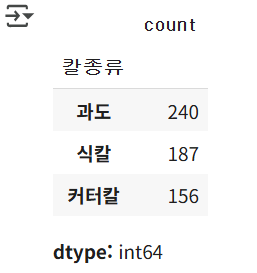

In [ ]:
# 칼 종류별(식칼, 과도, 커터칼) 정리된 폴더 구조 생성

import os
import shutil

origin = '/content/knives_dataset'
base_dir = '/content/knife_class_dataset'
classes = ['식칼', '과도', '커터칼']
os.makedirs(base_dir, exist_ok=True)

for folder in os.listdir(origin):
    for c in classes:
        if c in folder:
            target_dir = os.path.join(base_dir, c)
            os.makedirs(target_dir, exist_ok=True)
            for file in os.listdir(os.path.join(origin, folder)):
                src = os.path.join(origin, folder, file)
                dst = os.path.join(target_dir, file)
                shutil.copy(src, dst)


In [ ]:
# ImageDataGenerator로 칼 종류 기준 분류 학습용 데이터 구성

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 309 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


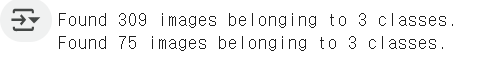

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers, optimizers

# 1. base model: EfficientNetB0 (ImageNet 가중치, fully connected layer 제거)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # feature extractor로만 사용

# 2. 분류용 새 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 클래스 수 = 3 (칼 종류)
])

# 3. 컴파일
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. 학습
history_effnet = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3208 - loss: 1.1581 - val_accuracy: 0.3600 - val_loss: 1.1056
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3105 - loss: 1.1445 - val_accuracy: 0.3600 - val_loss: 1.1224
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3597 - loss: 1.1191 - val_accuracy: 0.2800 - val_loss: 1.1085
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.2810 - loss: 1.1096 - val_accuracy: 0.3600 - val_loss: 1.0990
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4156 - loss: 1.0954 - val_accuracy: 0.3600 - val_loss: 1.0943
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3752 - loss: 1.0926 - val_accuracy: 0.3600 - val_loss: 1.0968
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3613 - loss: 1.0945 - val_accuracy: 0.3600 - val_loss: 1.0953
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3214 - loss: 1.1107 - val_accuracy: 0.3600 - val_loss: 1

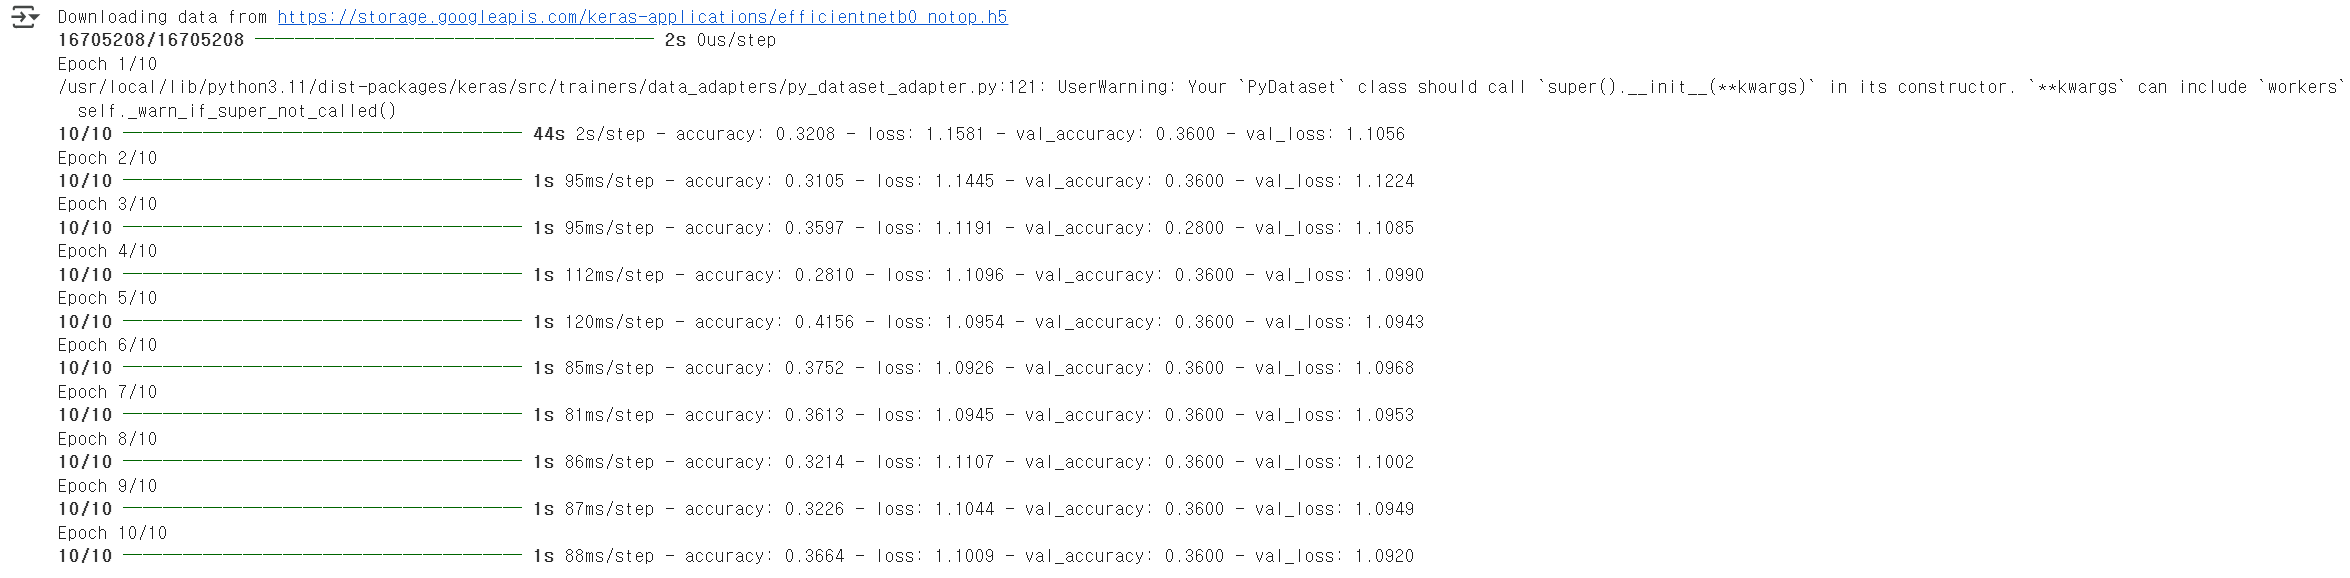

### EfficientNetB0 학습 결과 요약
- 학습 기간: 총 10 epoch

- 초기 성능:

  - Epoch 1에서 훈련 정확도 32.08%, 검증 정확도 36.00%

  - 손실도 높고, 성능이 낮게 시작 (train: 1.1581 / val: 1.1056)

- 학습 진행 중 변화:

  - Epoch 2~10까지 검증 정확도는 36.00%에서 고정

  - 훈련 정확도는 일부 epoch에서 상승했지만 불안정한 진동 형태

  - 검증 손실도 큰 변화 없이 1.09~1.12 수준에 머무름

- 최종 성능:

  - 훈련 정확도: 36.64%

  - 검증 정확도: 36.00% (Epoch 2~10 내내 변화 없음)

  - val_loss: 1.0920

  - 학습은 진행되었지만 성능 향상이 이루어지지 않음

- 특이사항:

  - 검증 정확도 변화가 거의 없고, 훈련 정확도도 불안정

  - 전이학습 성능이 제대로 반영되지 않았을 가능성

  - 모델 구조, learning rate, 데이터셋 적합성 등 점검 필요

In [ ]:
# 검증셋 예측값 저장

import numpy as np

val_gen.reset()
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# 파일 경로 목록도 저장
filenames = val_gen.filenames


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


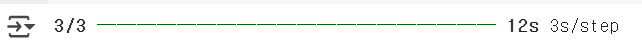

In [ ]:
# 예측 결과 DataFrame 만들기

import pandas as pd

df_pred = pd.DataFrame({
    '파일경로': filenames,
    '실제클래스': [class_labels[i] for i in true_classes],
    '예측클래스': [class_labels[i] for i in pred_classes]
})


In [ ]:
# df_meta와 merge (조건 붙이기)

# 파일명 컬럼 생성
df_pred['파일명'] = df_pred['파일경로'].apply(lambda x: x.split('/')[-1])

# df_meta에서 '파일명' 기준으로 merge
df_merged = pd.merge(df_pred, df_meta, on='파일명', how='left')


In [ ]:
# ✅ 조건별 정확도 분석

# 조도별 정확도
조도별정확도 = df_merged.groupby('조도').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("✅ 조도별 정확도:\n", 조도별정확도)

# 오클루전 여부별 정확도
오클루전정확도 = df_merged.groupby('오클루전').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 오클루전 여부별 정확도:\n", 오클루전정확도)

# 배경별 정확도
배경별정확도 = df_merged.groupby('배경').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 배경별 정확도:\n", 배경별정확도)

# 칼 종류별 정확도 (촬영된 칼 종류 기준)
칼종류정확도 = df_merged.groupby('칼종류').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 칼 종류별 정확도 (촬영 기준):\n", 칼종류정확도)

# 폴더명 기준 정확도 (영상 단위 분석)
폴더별정확도 = df_merged.groupby('폴더명').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 폴더별 정확도 (전체 조건 조합):\n", 폴더별정확도)


✅ 조도별 정확도:
 조도
bright    0.232258
dark      0.137056
dtype: float64

✅ 오클루전 여부별 정확도:
 오클루전
none    0.181818
yes     0.176136
dtype: float64

✅ 배경별 정확도:
 배경
desk          0.190476
floor         0.227273
kitchen       0.045872
livingroom    0.157895
window        1.000000
dtype: float64

✅ 칼 종류별 정확도 (촬영 기준):
 칼종류
과도     0.024631
식칼     0.201754
커터칼    1.000000
dtype: float64

✅ 폴더별 정확도 (전체 조건 조합):
 폴더명
knife01_bright_kitchen_식칼_none      0.000000
knife02_dark_desk_과도_none           0.021277
knife04_bright_floor_식칼_none        0.666667
knife05_dark_kitchen_과도_yes         0.000000
knife06_bright_window_커터칼_none      1.000000
knife07_bright_desk_식칼_yes          0.000000
knife08_dark_livingroom_커터칼_none    1.000000
knife09_dark_floor_커터칼_yes          1.000000
knife10_dark_window_커터칼_yes         1.000000
knife12_dark_kitchen_커터칼_none       1.000000
knife13_bright_window_커터칼_yes       1.000000
knife14_dark_floor_과도_yes           0.000000
knife15_bright_kitchen_과도_none      0.250000
knife16_bri

<ipython-input-11-65d8591a3c9e>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  조도별정확도 = df_merged.groupby('조도').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
<ipython-input-11-65d8591a3c9e>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  오클루전정확도 = df_merged.groupby('오클루전').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
<ipython-input-11-65d8591a3c9e>:12: DeprecationWarning: DataFrameGroupBy.appl

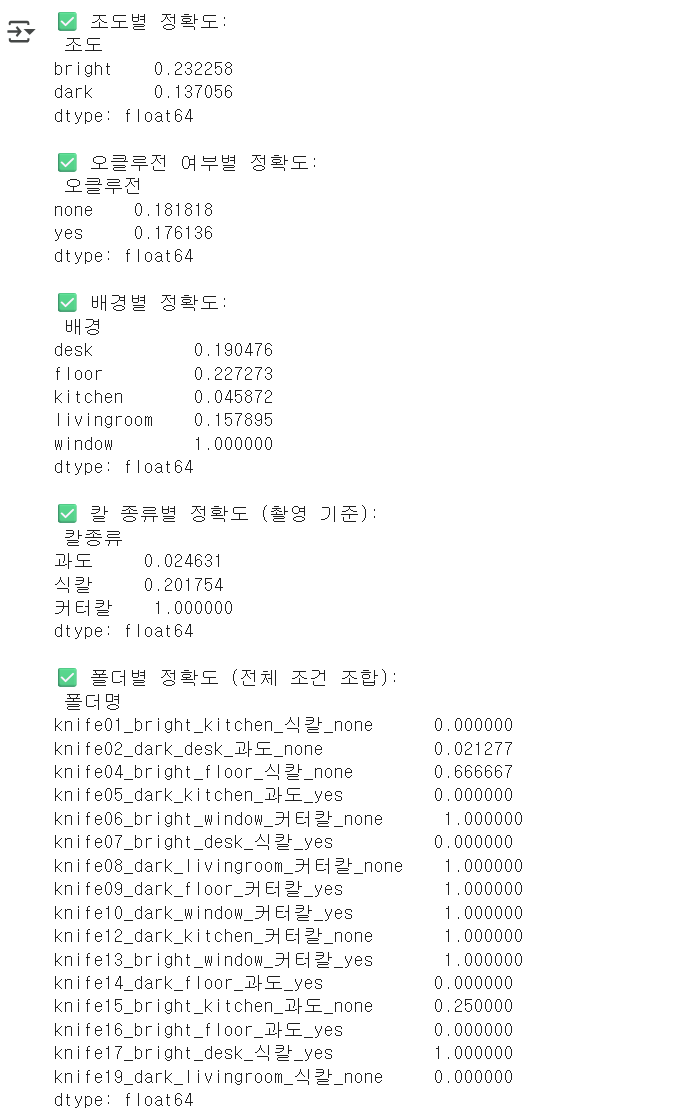


##  EfficientNetB0 조건별 정확도 분석 요약

####  1. **조도별 성능**

* **bright**: 23.23%
* **dark**: **13.71%** 🔻
  → **어두운 환경에서 성능 급감**, 조도 변화에 매우 민감한 모델로 보임

---

####  2. **오클루전(가림 여부)**

* **none**: 18.18%
* **yes**: 17.61%
  → 가림 여부에 따른 성능 차이는 **거의 없음**, 오클루전에는 비교적 중립적

---

####  3. **배경별 성능**

| 배경         | 정확도               |
| ---------- | ----------------- |
| window     | **100.00%** ✅ 압도적 |
| floor      | 22.73%            |
| desk       | 19.05%            |
| livingroom | 15.79%            |
| kitchen    | **4.59%** 🔻 최저   |

→ **window 배경에서는 모두 정확히 분류**, 반면 **kitchen에서는 거의 인식 실패**
→ **배경 편향 현상 뚜렷**

---

#### 4. **칼 종류별 정확도 (촬영 기준)**

| 칼 종류 | 정확도                |
| ---- | ------------------ |
| 커터칼  | **100.00%** ✅ 압도적  |
| 식칼   | 20.18%             |
| 과도   | **2.46%** 🔻 거의 실패 |

→ 커터칼에만 매우 높은 민감도 → **모델이 특정 클래스에만 치우쳐 있음**

---

####  5. **폴더별 성능 (조건 조합별)**

→ **강한 편향성**, 일부 조합은 완전 실패, 일부는 100%

* **최고 정확도 (100%)**:

  * `knife06_bright_window_커터칼_none`
  * `knife08_dark_livingroom_커터칼_none`
  * `knife09_dark_floor_커터칼_yes`
  * `knife10_dark_window_커터칼_yes`
  * `knife12_dark_kitchen_커터칼_none`
  * `knife13_bright_window_커터칼_yes`
  * `knife17_bright_desk_식칼_yes`

* **최저 정확도 (0%)**:

  * `knife01_bright_kitchen_식칼_none`
  * `knife05_dark_kitchen_과도_yes`
  * `knife07_bright_desk_식칼_yes`
  * `knife14_dark_floor_과도_yes`
  * `knife16_bright_floor_과도_yes`
  * `knife19_dark_livingroom_식칼_none`

→ 특정 조건에서는 **완전 분류 실패**, 전반적으로 **고르지 못한 성능**

---

**한 줄 요약** :
EfficientNetB0는 **커터칼과 window 배경에만 과도하게 반응하는 경향**을 보이며, 다른 클래스나 환경에서는 성능이 급감하여, **강한 편향성과 일반화 부족 문제가 드러난 모델**로 평가된다.


# 모델 학습 결과 시각화


## (1) EfficientNetB0 학습 및 검증 정확도 변화 (Accuracy Plot)

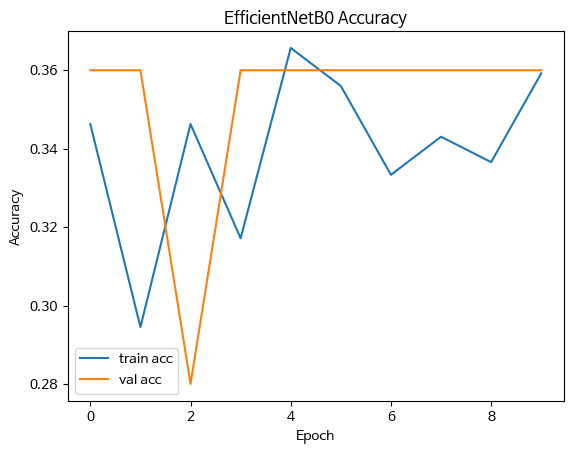

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

plt.plot(history_effnet.history['accuracy'], label='train acc')
plt.plot(history_effnet.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNetB0 Accuracy')
plt.legend()
plt.show()


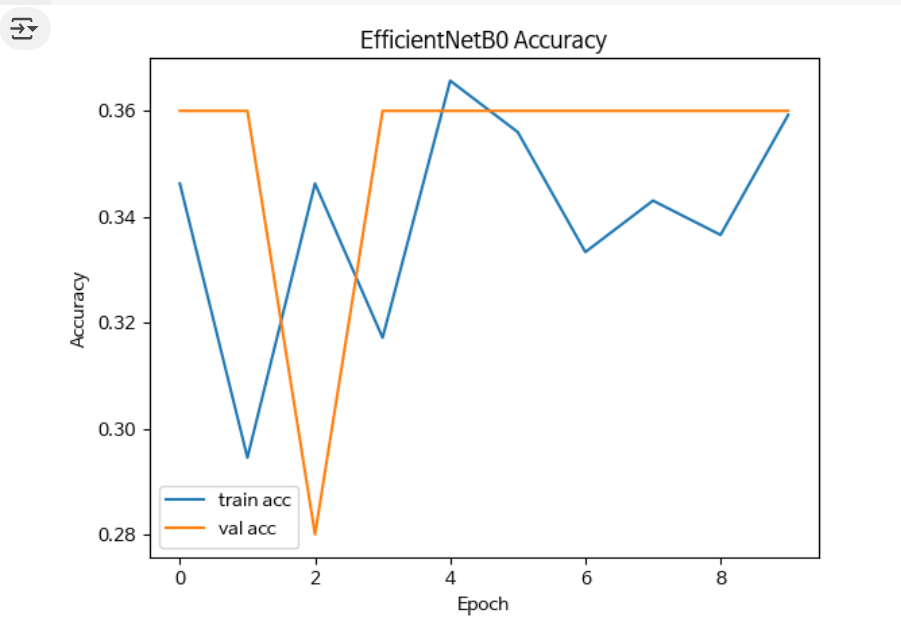

## Accuracy Plot 해석 요약
1) 전반적 특징

- 훈련 정확도는 10 epoch 동안 상승과 하락을 반복하며 불안정한 추세

- 검증 정확도는 Epoch 1부터 36%에서 고정, 이후 학습이 일관되게 정체

- 훈련-검증 모두 변화 폭이 작고 성능 향상이 거의 없음

2) 세부 분석
(1) 초기 Epoch (0~2)

- 훈련 정확도와 검증 정확도 모두 30%대 초반에서 시작

- Epoch 2에서 검증 정확도가 28%로 하락한 후 다시 회복

→ 전이학습 효과가 거의 드러나지 않음, 학습 불안정

(2) 중반 Epoch (3~5)

- 훈련 정확도가 일시적으로 상승하지만 불규칙한 진동 형태

- 검증 정확도는 36% 수준에서 고정, 모델이 특정한 범위 이상 학습하지 못하는 양상

(3) 후반 Epoch (6~9)

- 훈련 정확도는 소폭 변동하나 36~37% 이상으로 오르지 않음

- 검증 정확도는 여전히 변화 없음

→ 모델이 더 이상 성능을 개선할 여지를 찾지 못함, 학습 실패 가능성

3) 한 줄 요약

EfficientNetB0는 학습 전반에 걸쳐 성능이 정체되었으며, 전이학습의 효과도 발휘되지 못한 채 정확도 36% 수준에서 학습이 멈춰버린 비효율적인 결과를 보였다.

# (2) EfficientNetB0의 클래스별 예측 정확도 (Confusion Matrix)

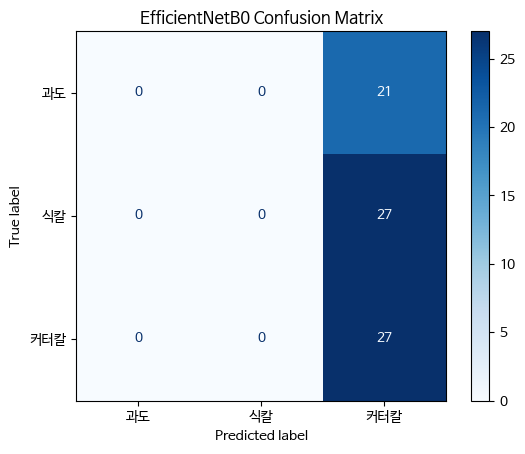

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rc('font', family='NanumBarunGothic')

cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("EfficientNetB0 Confusion Matrix")
plt.show()


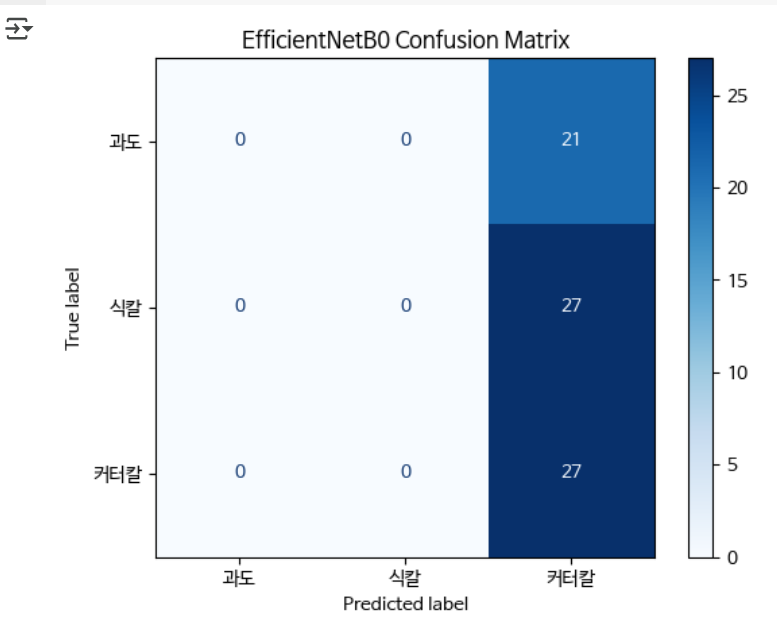


## Confusion Matrix 해석 요약
1) 전반적 특징
- 모든 예측이 단 하나의 클래스인 커터칼로 집중됨

- 과도, 식칼 클래스는 단 1건도 정답으로 예측되지 않음

→ 모델이 클래스 구분을 전혀 수행하지 못한 상태, 학습 실패에 가까움

2) 클래스별 해석

🔹 과도 (True label: 과도)
예측: 커터칼(21)

→ 100% 오분류, 과도에 대한 인식 자체가 이루어지지 않음

🔹 식칼 (True label: 식칼)
예측: 커터칼(27)

→ 마찬가지로 전부 오분류, 식칼도 모델이 구분하지 못함

🔹 커터칼 (True label: 커터칼)
예측: 커터칼(27)

→ 정답률 100%, 하지만 모든 클래스가 이 클래스로 예측되었기에 무의미한 정확도

3) 한 줄 요약

EfficientNetB0는 세 클래스를 모두 커터칼로만 예측하는 극단적인 편향을 보이며, 사실상 분류 기능을 수행하지 못한 상태로 해석된다. 학습 데이터 처리, 전이학습 전략, 하이퍼파라미터 설정 등 전반적인 점검이 필요하다.

# (3) 조건별 EfficientNetB0 정확도 비교 (Bar Plot)

In [ ]:
plt.rc('font', family='NanumBarunGothic')

def plot_accuracy_bar(data, title):
    plt.figure(figsize=(10, 5))
    plt.bar(data.index, data.values, color='lightsteelblue')
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xlabel("Category")
    plt.xticks(rotation=65, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 각 조건별 시각화
plot_accuracy_bar(조도별정확도, "Accuracy by Lighting (EfficientNetB0")
plot_accuracy_bar(오클루전정확도, "Accuracy by Occlusion (EfficientNetB0)")
plot_accuracy_bar(배경별정확도, "Accuracy by Background (EfficientNetB0)")
plot_accuracy_bar(칼종류정확도, "Accuracy by Knife Type (EfficientNetB0)")
plot_accuracy_bar(폴더별정확도, "Accuracy by Folder (EfficientNetB0)")


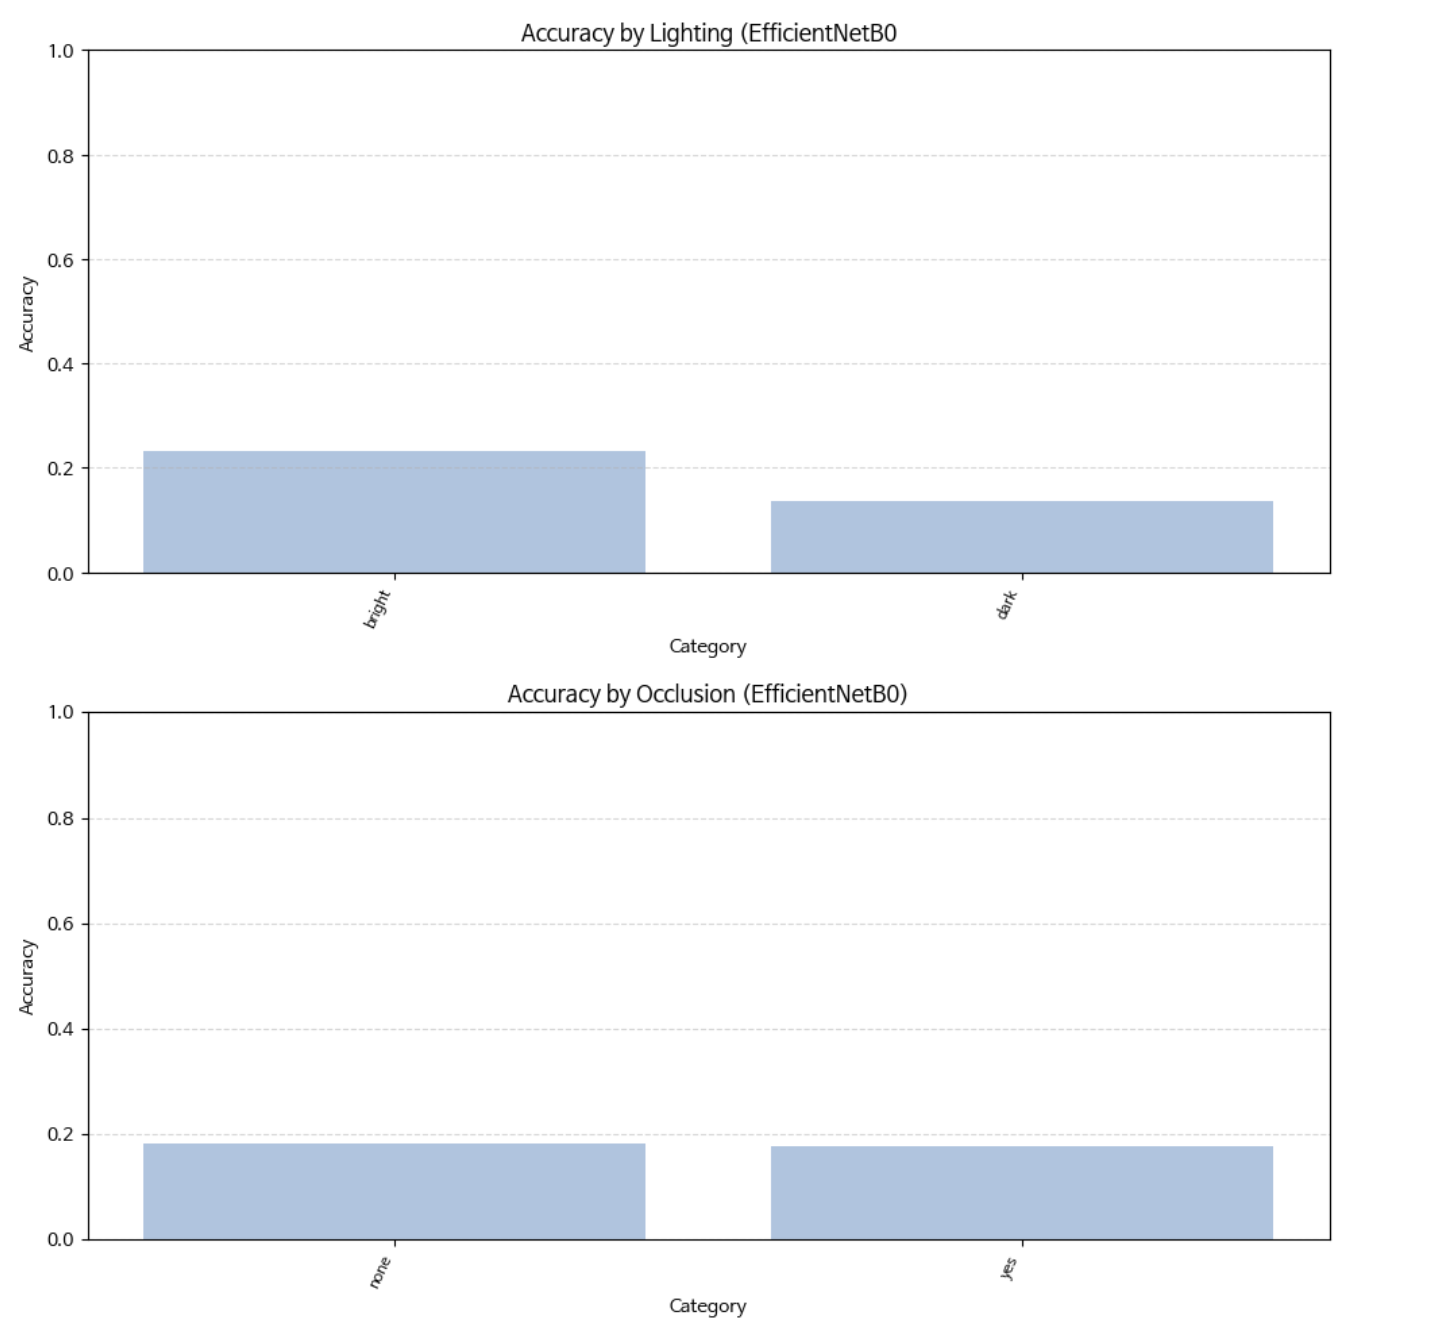

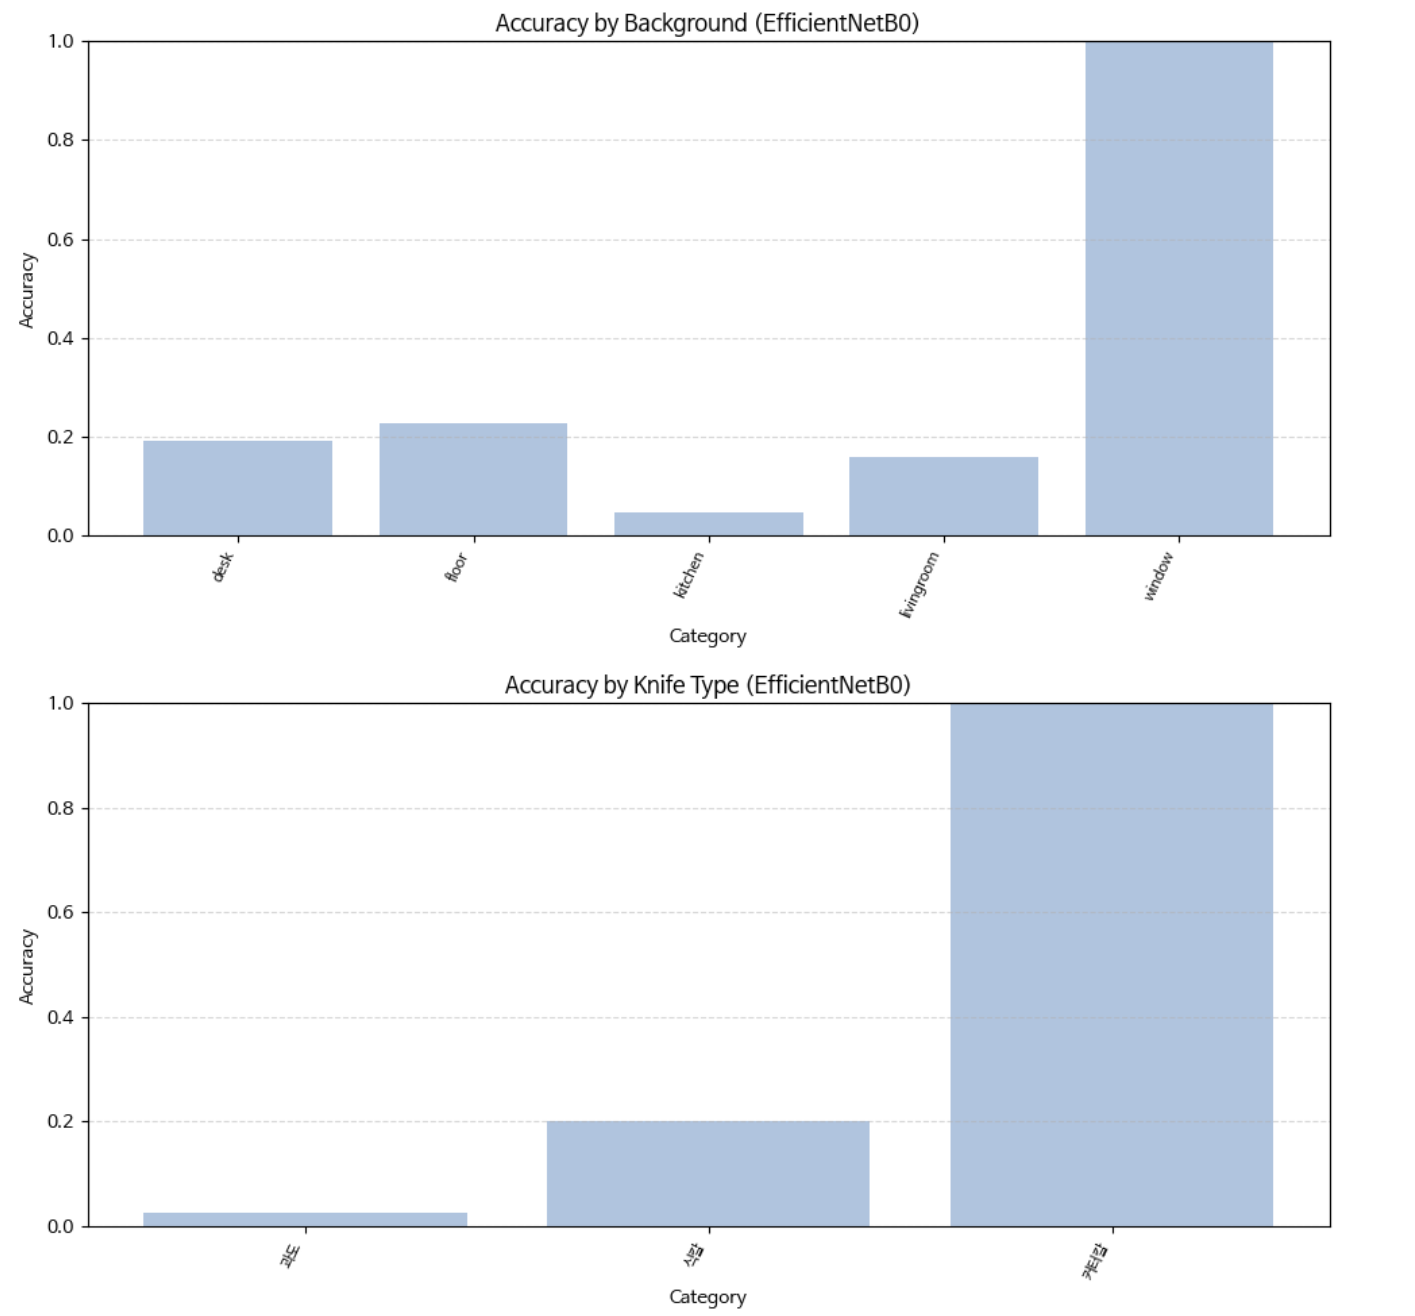

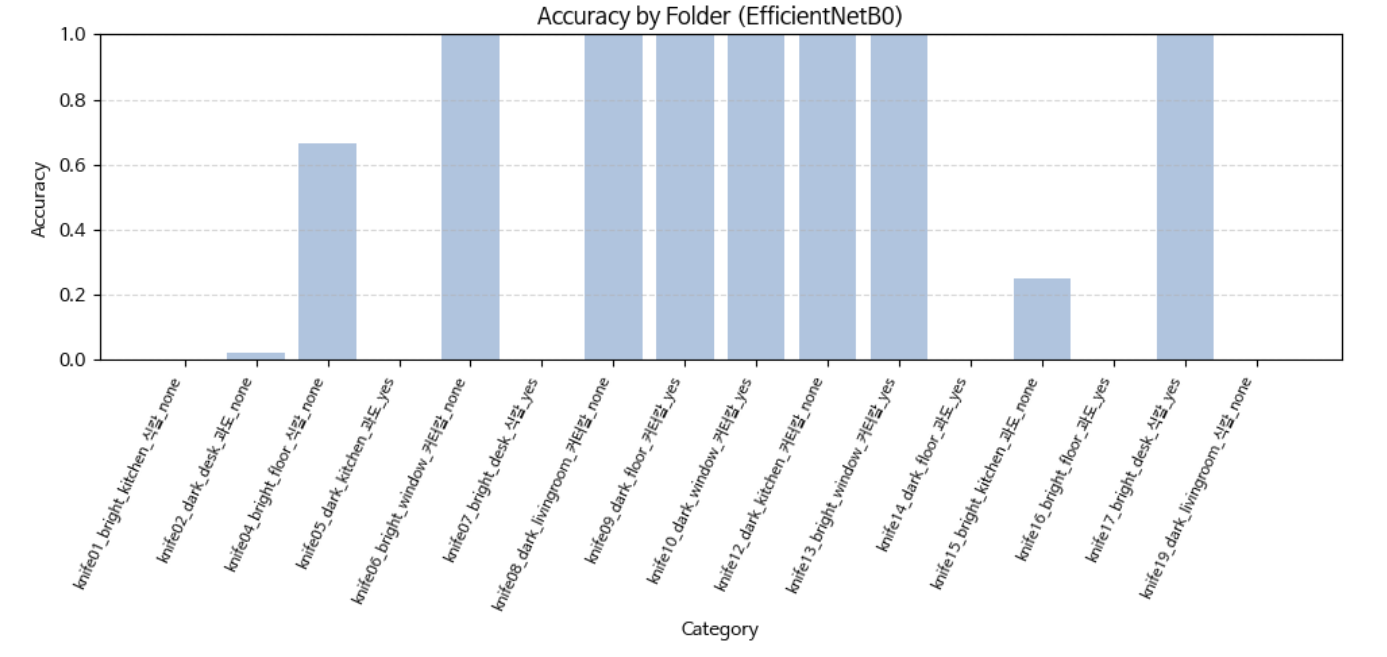

# 조건별 정확도 Bar Plot 해석 요약
1️⃣ 조도별 정확도 (Accuracy by Lighting)

bright: 23.2%, dark: 13.7%
→ 조도 변화에 매우 민감하며, 어두운 환경에서 성능 급감

2️⃣ 오클루전 여부별 정확도 (Accuracy by Occlusion)

none: 18.2%, yes: 17.6%
→ 오클루전 여부는 성능에 큰 영향을 주지 않음, 기본적인 분류 성능 자체가 낮음

3️⃣ 배경별 정확도 (Accuracy by Background)

최고: window(100%) / 최저: kitchen(4.6%)
→ 특정 배경에만 의존하는 편향적 학습 결과, 대부분 배경에서 인식 실패

4️⃣ 칼 종류별 정확도 (Accuracy by Knife Type)

커터칼: 100.0%, 식칼: 20.2%, 과도: 2.5%
→ 모든 예측이 커터칼에 집중되며, 극단적 클래스 편향이 나타남

5️⃣ 폴더(조건 조합)별 정확도 (Accuracy by Folder)

최고: knife06~13 (100%) / 최저: knife01, 05, 07, 14, 16, 19 (0%)
→ 일부 조합만 인식 성공, 대부분 조건에서 완전 실패 → 학습 효과 거의 없음

[한 줄 요약]
EfficientNetB0는 조도·배경·칼 종류에 대한 편향이 심하며, 전체적으로 학습이 실패한 모델로 판단된다.

In [ ]:
resnet_df = df_merged.copy()
resnet_df.to_csv("efficientnet_results.csv", index=False, encoding='cp949')

# EfficientNetB0 최종 요약

EfficientNetB0는 전반적으로 모든 조건에서 성능이 낮았으며, 커터칼 외의 클래스에 대한 분류가 거의 이루어지지 않았다. 특정 조건에서만 높은 정확도를 보이며, 극단적인 편향과 학습 실패 양상을 드러냈다.